<a href="https://colab.research.google.com/github/fred2167/ResNet-50-FPN/blob/master/ResNet50_w_FPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import time
import math
import matplotlib.pyplot as plt

to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}

# for mAP evaluation
# !rm -rf mAP
# !git clone https://github.com/Cartucho/mAP.git
# !rm -rf mAP/input/*


In [ ]:
train_dataset = torchvision.datasets.VOCDetection(root="./content",year="2007",image_set="train",download=True)
val_dataset =  torchvision.datasets.VOCDetection(root="./content",year="2007",image_set="val",download=True)
import json
print(json.dumps(train_dataset[1][1]['annotation'], indent=2))


Using downloaded and verified file: ./content/VOCtrainval_06-Nov-2007.tar
{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC2007 Database",
    "annotation": "PASCAL VOC2007",
    "image": "flickr",
    "flickrid": "228217974"
  },
  "owner": {
    "flickrid": "genewolf",
    "name": "whiskey kitten"
  },
  "size": {
    "width": "480",
    "height": "364",
    "depth": "3"
  },
  "segmented": "0",
  "object": [
    {
      "name": "person",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "185",
        "ymin": "62",
        "xmax": "279",
        "ymax": "199"
      }
    },
    {
      "name": "horse",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "90",
        "ymin": "78",
        "xmax": "403",
        "ymax": "336"
      }
    }
  ]
}


In [ ]:
def pascal_voc2007_loader(dataset, batch_size, num_workers=0):
  """
  Data loader for Pascal VOC 2007.
  https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
  """
  from torch.utils.data import DataLoader
  # turn off shuffle so we can index the original image
  train_loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=False, pin_memory=True,
                            num_workers=num_workers,
                            collate_fn=voc_collate_fn)
  return train_loader


class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19,'background':20
}
idx_to_class = {i:c for c, i in class_to_idx.items()}


from torchvision import transforms

def voc_collate_fn(batch_lst, reshape_size=224):
    preprocess = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    
    batch_size = len(batch_lst)
    
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)
    
    max_num_box = max(len(batch_lst[i][1]['annotation']['object']) \
                      for i in range(batch_size))

    box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)
    w_list = []
    h_list = []
    img_id_list = []
    
    for i in range(batch_size):
      img, ann = batch_lst[i]
      w_list.append(img.size[0]) # image width
      h_list.append(img.size[1]) # image height
      img_id_list.append(ann['annotation']['filename'])
      img_batch[i] = preprocess(img)
      all_bbox = ann['annotation']['object']
      if type(all_bbox) == dict: # inconsistency in the annotation file
        all_bbox = [all_bbox]
      for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_batch[i][bbox_idx] = torch.Tensor([float(bbox['xmin']), float(bbox['ymin']),
          float(bbox['xmax']), float(bbox['ymax']), class_to_idx[obj_cls]])
    
    h_batch = torch.tensor(h_list)
    w_batch = torch.tensor(w_list)

    return img_batch, box_batch, w_batch, h_batch, img_id_list

In [ ]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `img` of shape `(B, 3, 224, 224)`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `ann` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `ann[i, j] = (x_tl, y_tl, x_br, y_br, class)` gives information about the `j`th object in `img[i]`. The position of the top-left corner of the box is `(x_tl, y_tl)` and the position of the bottom-right corner of the box is `(x_br, y_br)`. These positions are in the coordinate system of the original image (before it was resized to 224 x 224). `class` is an integer giving the category label for this bounding box.

Each image can have different numbers of objects. If `img[i]` has $N_i$ objects, then $N=\max_i N_i$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of $anns[i]$ contain annotations; the remaining rows are padded with -1.

In [ ]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)

print('Image 1 has only two annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nImage 2 has six annotated objects:, so ann[2] is not padded:')
print(ann[2])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 6, 5])
Image 1 has only two annotated objects, so ann[1] is padded with -1:
tensor([[185.,  62., 279., 199.,  14.],
        [ 90.,  78., 403., 336.,  12.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Image 2 has six annotated objects:, so ann[2] is not padded:
tensor([[  9., 230., 245., 500.,   1.],
        [230., 220., 334., 500.,   1.],
        [  2., 178.,  90., 500.,   1.],
        [  2.,   1., 117., 369.,  14.],
        [  3.,   2., 243., 462.,  14.],
        [225.,   1., 334., 486.,  14.]])

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


In [ ]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred of pixels in
  width/height while the activation map is of size 7x7.

  Input:
  - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
  - w_pixel: Number of pixels in the width side of the original image, of shape B
  - h_pixel: Number of pixels in the height side of the original image, of shape B
  - w_amap: Number of pixels in the width side of the activation map, scalar
  - h_amap: Number of pixels in the height side of the activation map, scalar
  - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

  Output:
  - resized_bbox: Resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
  
  if bbox.shape[0] == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()

  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox

def data_visualizer(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image. Support both GT box input and proposal input.
  
  Input:
  - img: PIL Image input
  - idx_to_class: Mapping from the index (0-19) to the class name
  - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
          the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
  - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
          N' is the number of predicted boxes, 6 indicates
          (x_tl, y_tl, x_br, y_br, class, object confidence score)
  """

  img_copy = np.array(img).astype('uint8')

  if bbox is not None:
    for bbox_idx in range(bbox.shape[0]):
      one_bbox = bbox[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (255, 0, 0), 2)
      if bbox.shape[1] > 4: # if class info provided
        obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
        cv2.putText(img_copy, '%s' % (obj_cls),
                  (one_bbox[0], one_bbox[1]+15),
                  cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  if pred is not None:
    for bbox_idx in range(pred.shape[0]):
      one_bbox = pred[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (0, 255, 0), 2)
      
      if pred.shape[1] > 4: # if class and conf score info provided
        obj_cls = idx_to_class[pred[bbox_idx][4].item()]
        conf_score = pred[bbox_idx][5].item()
        cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                    (one_bbox[0], one_bbox[1]+15),
                    cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

In [ ]:
class ResNet50_FPN (nn.Module):
  '''
  Image feature extraction with ResNet50 AND feature pyramid network
  '''
  def __init__(self,out_channel = 256):
    super().__init__()

    self.ResNet50  = torchvision.models.resnet50(pretrained=True)

    # Freeze all layer in ResNet50
    for i in self.ResNet50.named_parameters():
      i[1].requires_grad = False


    # Separte each module in ResNet50
    self.module_0 = nn.Sequential(*list(self.ResNet50.children())[:5]) # Input: (3,224,224), Output (256,56,56)
    self.module_1 = nn.Sequential(*list(self.ResNet50.children())[5])  # Input: (256,56,56), Output (512,28,28)
    self.module_2 = nn.Sequential(*list(self.ResNet50.children())[6])  # Input: (512,28,28), Output (1024,14,14)
    self.module_3 = nn.Sequential(*list(self.ResNet50.children())[7:-2]) # Remove last liner classifier layer and Average pool layer
                                                                         # Input: (1024,14,14), Output (2048,7,7)

    # Feature pyramid modules
    self.upSample = nn.UpsamplingNearest2d(scale_factor=2)
    self.laten256 = nn.Conv2d(in_channels=256,out_channels=out_channel,kernel_size=1,stride=1)
    self.laten512 = nn.Conv2d(in_channels=512,out_channels=out_channel,kernel_size=1,stride=1)
    self.laten1024 = nn.Conv2d(in_channels=1024,out_channels=out_channel,kernel_size=1,stride=1)
    self.laten2048 = nn.Conv2d(in_channels=2048,out_channels=out_channel,kernel_size=1,stride=1)

    self.sharedHead = nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=3,stride=1,padding=1)                                                                  
  
  def forward(self,img):
    '''
    Inputs:
    - img : Batch of resized images, of shape (B,3,224,224)

    Outputs:
    - pyramid : list of features map provide by the pyramid netowork
    '''

   
    # Bottom up pathway, extract feature maps using various stage of modules
    feat0 = self.module_0(img)         #(B,256,56,56)
    feat1 = self.module_1(feat0)       #(B,512,28,28)
    feat2 = self.module_2(feat1)       #(B,1024,14,14)
    feat3 = self.module_3(feat2)       #(B,2048,7,7)

    # Top down pathway
    M3  = self.laten2048(feat3)                          #(B,256,7,7)
    M2  = self.laten1024(feat2) + self.upSample(M3)      #(B,256,14,14)
    M1  = self.laten512(feat1) + self.upSample(M2)       #(B,256,28,28)
    M0  = self.laten256(feat0) + self.upSample(M1)       #(B,256,56,56)

    # Another SHARED 3 by 3 conv to reduce aliasing effect of upsampling
    P3  = M3                         #(B,256,7,7), did not apply shared head since there is no upsampling yet.
    P2  = self.sharedHead(M2)        #(B,256,14,14)
    P1  = self.sharedHead(M1)        #(B,256,28,28)
    P0  = self.sharedHead(M0)        #(B,256,56,56)
 
    pyramid = [P0,P1,P2,P3]

    return pyramid



In [ ]:
class FPN_proposal (nn.Module):

  def __init__(self, in_dim=256, hidden_dim=256, num_anchors=3, drop_ratio=0.3):
    '''
    num_achors reduce to 3 for each level of pyramid. One size with three scale at each level
    size: {32,64,128,256} and ratio: {1:2,1:1,2:1}
    '''
    super().__init__()

    self.num_anchors = num_anchors

    self.head = nn.Sequential(
                              nn.Conv2d(in_channels=in_dim,out_channels=hidden_dim,kernel_size=3,stride=1,padding=1),
                              nn.Dropout2d(drop_ratio),
                              nn.LeakyReLU(),
                              nn.Conv2d(in_channels= hidden_dim,out_channels = num_anchors*6,kernel_size=1,stride=1) # Each anchor has 5 values (object scores, xtl, ytl, xbr, ybr)
                              )
    self.anchor_list = []
  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    Inputs:
    - anchor_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A anchors at each point in an H x W grid.
    - anchor_idx: int64 Tensor of shape (M,) giving anchor indices to extract

    Returns:
    - extracted_anchors: Tensor of shape (M, D) giving anchor data for each
      of the anchors specified by anchor_idx.
    """
    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_anchors = anchor_data[anchor_idx]
    return extracted_anchors

  def _generateProposal(self,anchors, offsets):
    """
    Proposal generator.

    Inputs:
    - anchors: Anchor boxes, of shape (B, A, H', W', 4). Anchors are represented
      by the coordinates of their top-left and bottom-right corners.
    - offsets: Transformations of shape (B, A, H', W', 4) that will be used to
      convert anchor boxes into region proposals. The transformation
      offsets[b, a, h, w] = (tx, ty, tw, th) will be applied to the anchor
      anchors[b, a, h, w]. For YOLO, assume that tx and ty are in the range
      (-0.5, 0.5).
    - method: Which transformation formula to use, either 'YOLO' or 'FasterRCNN'
    
    Outputs:
    - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
      coordinates of their top-left and bottom-right corners. Applying the
      transform offsets[b, a, h, w] to the anchor [b, a, h, w] should give the
      proposal proposals[b, a, h, w].
  
    """

    proposals = torch.zeros_like(anchors)
    proposals_center = torch.zeros_like(anchors)
    anchors_center = torch.zeros_like(anchors)

    anchors_center[:,:,:,:,0] = (anchors[:,:,:,:,2] + anchors[:,:,:,:,0]) / 2. # (Xbr - Xtl) / 2 
    anchors_center[:,:,:,:,1] = (anchors[:,:,:,:,1] + anchors[:,:,:,:,3]) / 2. # (Ytl - Ybr) / 2
    anchors_center[:,:,:,:,2] = anchors[:,:,:,:,2] - anchors[:,:,:,:,0] # W
    anchors_center[:,:,:,:,3] = anchors[:,:,:,:,3] - anchors[:,:,:,:,1] # H, for bottom left and top right cordinates

    proposals_center[:,:,:,:,0] = anchors_center[:,:,:,:,0] + offsets[:,:,:,:,0] * anchors_center[:,:,:,:,2]
    proposals_center[:,:,:,:,1] = anchors_center[:,:,:,:,1] + offsets[:,:,:,:,1] * anchors_center[:,:,:,:,3]
    proposals_center[:,:,:,:,2] = anchors_center[:,:,:,:,2] * torch.exp(offsets[:,:,:,:,2]) # W
    proposals_center[:,:,:,:,3] = anchors_center[:,:,:,:,3] * torch.exp(offsets[:,:,:,:,3]) # H
    

    # However, the answer provided below are for **bottom left** and **top right** cordinates
    proposals[:,:,:,:,0] = proposals_center[:,:,:,:,0] - proposals_center[:,:,:,:,2] / 2
    proposals[:,:,:,:,1] = proposals_center[:,:,:,:,1] - proposals_center[:,:,:,:,3] / 2
    proposals[:,:,:,:,2] = proposals_center[:,:,:,:,0] + proposals_center[:,:,:,:,2] / 2
    proposals[:,:,:,:,3] = proposals_center[:,:,:,:,1] + proposals_center[:,:,:,:,3] / 2

    return proposals

  def forward(self, feature, pos_anchor_coord=None, \
              pos_anchor_idx=None, neg_anchor_idx=None):
    """
    Run the forward pass of the proposal module.
    
    Inputs:
    - feature: Tensor of shape (B, in_dim, H', W') giving features from
      the feature pyramid backbone network.
    - pos_anchor_coord: Tensor of shape (M, 4) giving the coordinates of
      positive anchors. Anchors are specified as (x_tl, y_tl, x_br, y_br) with
      the coordinates of the top-left corner (x_tl, y_tl) and bottom-right
      corner (x_br, y_br). During inference this is None.
    - pos_anchor_idx: int64 Tensor of shape (M,) giving the indices of positive
      anchors. During inference this is None.
    - neg_anchor_idx: int64 Tensor of shape (M,) giving the indicdes of negative
      anchors. During inference this is None.

      The outputs from this module are different during training and inference.
      
      During training, pos_anchor_coord, pos_anchor_idx, and neg_anchor_idx are
      all provided, and we only output predictions for the positive and negative
      anchors. During inference, these are all None and we must output predictions
      for all anchors.

    Outputs (during training):
    - conf_scores: Tensor of shape (2M, 1) giving the classification scores
      (object vs background) for each of the M positive and M negative anchors.
    - offsets: Tensor of shape (M, 4) giving predicted transforms for the
      M positive anchors.
    - proposals: Tensor of shape (M, 4) giving predicted region proposals for
      the M positive anchors.

    Outputs (during inference):
    - conf_scores: Tensor of shape (B, A, 2, H', W') giving the predicted
      classification scores (object vs background) for all anchors
    - offsets: Tensor of shape (B, A, 4, H', W') giving the predicted transforms
      for all anchors
    """
    if pos_anchor_coord is None or pos_anchor_idx is None or neg_anchor_idx is None:
      mode = 'eval'
    else:
      mode = 'train'

    conf_scores, offsets, proposals = None, None, None

    
    proposal_package = self.head(feature)                                     #(B,A*5,H',W')
    B,_,H,W = proposal_package.shape
    proposal_package = proposal_package.reshape(B,self.num_anchors,6,H,W)     #(B,A,5,H',W')

    conf_score = proposal_package[:,:,0:2,:,:]                                #(B,A,2,H',W')
    anchor_offsets = proposal_package[:,:,2:,:,:]                             #(B,A,4,H',W')

    if mode == "train":
      M = pos_anchor_coord.shape[0]
      
      # Confident scores, want both positive and negative anchors conf socres to calculate loss downstream
      pos_conf_score = self._extract_anchor_data(conf_score,pos_anchor_idx)     #(M,1)
      neg_conf_score = self._extract_anchor_data(conf_score,neg_anchor_idx)     #(M,1)
      conf_scores = torch.cat((pos_conf_score,neg_conf_score),dim=0)            #(2M,1)
      assert conf_scores.shape == (2*M,2)

      # Porposal offsets, only want positive anchors
      offsets = self._extract_anchor_data(anchor_offsets,pos_anchor_idx)        #(M,4)
      assert offsets.shape == (M,4)

      # Proposals, only want positve proposals
      proposals = self._generateProposal(pos_anchor_coord.view(M,1,1,1,4),
                                         offsets.view(M,1,1,1,4))               #(M,1,1,1,4)
      assert proposals.shape == (M,1,1,1,4)

    # During Inference
    else:
      offsets = anchor_offsets
      conf_scores = conf_score


    if mode == 'train':
      return conf_scores, offsets, proposals
    elif mode == 'eval':
      return conf_scores, offsets

In [ ]:
size = 2
anchor_list = [[[size, size*2], [size, size], [size*2, size]],[[size*2, size*4], [size*2, size*2], [size*4, size*2]],[[size*4, size*4*2], [size*4, size*4], [size*4*2, size*4]],[[size*8, size*8*2], [size*8, size*8], [size*8*2, size*8]]]
anchor_list

[[[2, 4], [2, 2], [4, 2]],
 [[4, 8], [4, 4], [8, 4]],
 [[8, 16], [8, 8], [16, 8]],
 [[16, 32], [16, 16], [32, 16]]]

In [ ]:
class RPN (nn.Module):

  def __init__(self,anchor_size = 8,device="cuda"):
    super().__init__()
    self.device = device
    size = anchor_size
    anchor_list = [[[size, size*2], [size, size], [size*2, size]],[[size*2, size*4], [size*2, size*2], [size*4, size*2]],\
                   [[size*4, size*4*2], [size*4, size*4], [size*4*2, size*4]],[[size*8, size*8*2], [size*8, size*8], [size*8*2, size*8]]]
    # anchor_list = [[[256,256],[256,512],[256,512]],[[128,128],[128,256],[256,128]],[[64,64],[64,128],[128,64]],\
    #                [[32,32],[32,64],[64,32]]]
    # anchor_list = [[[256,256],[256,512],[256,512]],[[256,256],[256,512],[256,512]],[[256,256],[256,512],[256,512]],\
    #                 [[256,256],[256,512],[256,512]]]
    self.feature_extractor = ResNet50_FPN()
    self.proposal = FPN_proposal()
    self.anchor_list = torch.tensor(anchor_list,device=device) #(num of features maps, num_anchors,width and height)

  def _GenerateGrid(self,batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
    """
    Return a grid cell given a batch size (center coordinates).

    Inputs:
    - batch_size, B
    - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
    - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
    - W' and H' are always 7 in our case while w and h might vary.
    
    Outputs:
    grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
          of the centers of each feature for a feature map of shape (B, D, H', W')
    """
    w_range = torch.arange(0, w_amap, dtype=dtype, device=self.device) + 0.5
    h_range = torch.arange(0, h_amap, dtype=dtype, device=self.device) + 0.5

    w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
    h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
    grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
    grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

    return grid

  def _GenerateAnchor(self,anc, grid):
    """
    Anchor generator.

    Inputs:
    - anc: Tensor of shape (A, 2) giving the shapes of anchor boxes to consider at
      each point in the grid. anc[a] = (w, h) gives the width and height of the
      a'th anchor shape.
    - grid: Tensor of shape (B, H', W', 2) giving the (x, y) coordinates of the
      center of each feature from the backbone feature map. This is the tensor
      returned from GenerateGrid.
    
    Outputs:
    - anchors: Tensor of shape (B, A, H', W', 4) giving the positions of all
      anchor boxes for the entire image. anchors[b, a, h, w] is an anchor box
      centered at grid[b, h, w], whose shape is given by anc[a]; we parameterize
      boxes as anchors[b, a, h, w] = (x_tl, y_tl, x_br, y_br), where (x_tl, y_tl)
      and (x_br, y_br) give the xy coordinates of the top-left and bottom-right
      corners of the box.
    """
    anchors = None

    A = anc.shape[0]
    B,H,W,_ = grid.shape
    anchors = torch.zeros((B,A,H,W,4),dtype=torch.float,device=self.device)

    anc = anc.reshape(1,A,1,1,2) 
    grid = grid.unsqueeze(1) # (B,1,H',W',2)

    anc = anc.clone() / 2.

    # (X_bl,Y_bl,X_tr,Y_tr) cordinates, 
    # appearently the answer provided below are using **bottom left** and **top right** cordinates
    anchors[:,:,:,:,0] = grid[:,:,:,:,0] - anc[:,:,:,:,0]
    anchors[:,:,:,:,1] = grid[:,:,:,:,1] - anc[:,:,:,:,1]
    anchors[:,:,:,:,2] = grid[:,:,:,:,0] + anc[:,:,:,:,0]
    anchors[:,:,:,:,3] = grid[:,:,:,:,1] + anc[:,:,:,:,1]

    return anchors

  def _IoU(self,proposals, bboxes):
    """
    Compute intersection over union between sets of bounding boxes.

    Inputs:
    - proposals: Proposals of shape (B, A, H', W', 4)
    - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
      Each ground-truth box is represented as tuple (x_lr, y_lr, x_rb, y_rb, class).
      If image i has fewer than N boxes, then bboxes[i] will be padded with extra
      rows of -1.
    
    Outputs:
    - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
      the IoU between one element of proposals[b] and bboxes[b, n].

    For this implementation you DO NOT need to filter invalid proposals or boxes;
    in particular you don't need any special handling for bboxxes that are padded
    with -1.
    """

    B,A,H,W,_ = proposals.shape
  
    proposals = proposals.reshape(B,-1,1,4)
    bboxes = bboxes.unsqueeze(1) # (B,1,N,5)

    # Note: Also using **bottom left** and **top right** xy cordinates
    intersect_x_bl = torch.max(proposals[:,:,:,0],bboxes[:,:,:,0])
    intersect_y_bl = torch.max(proposals[:,:,:,1],bboxes[:,:,:,1])
    intersect_x_tr = torch.min(proposals[:,:,:,2],bboxes[:,:,:,2])
    intersect_y_tr = torch.min(proposals[:,:,:,3],bboxes[:,:,:,3])
    
    # clamp at 0 for no intersection
    intersect_W = (intersect_x_tr - intersect_x_bl).clamp(0)
    intersect_H = (intersect_y_tr - intersect_y_bl).clamp(0)

    intersect_area = intersect_W * intersect_H
    
    proposals_area = (proposals[:,:,:,2] - proposals[:,:,:,0]) * (proposals[:,:,:,3] - proposals[:,:,:,1]) 
    bboxes_area = (bboxes[:,:,:,2] - bboxes[:,:,:,0]) * (bboxes[:,:,:,3] - bboxes[:,:,:,1]) 

    union_area  = proposals_area + bboxes_area - intersect_area
    iou_mat = intersect_area / union_area

    return iou_mat
  
  def _GenerateProposal(self,anchors, offsets):
    """
    Proposal generator.

    Inputs:
    - anchors: Anchor boxes, of shape (B, A, H', W', 4). Anchors are represented
      by the coordinates of their top-left and bottom-right corners.
    - offsets: Transformations of shape (B, A, H', W', 4) that will be used to
      convert anchor boxes into region proposals. The transformation
      offsets[b, a, h, w] = (tx, ty, tw, th) will be applied to the anchor
      anchors[b, a, h, w]. For YOLO, assume that tx and ty are in the range
      (-0.5, 0.5).
    
    Outputs:
    - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
      coordinates of their top-left and bottom-right corners. Applying the
      transform offsets[b, a, h, w] to the anchor [b, a, h, w] should give the
      proposal proposals[b, a, h, w].
    
    """

    proposals = torch.zeros_like(anchors)
    proposals_center = torch.zeros_like(anchors)
    anchors_center = torch.zeros_like(anchors)

    anchors_center[:,:,:,:,0] = (anchors[:,:,:,:,2] + anchors[:,:,:,:,0]) / 2. # (Xbr - Xtl) / 2 
    anchors_center[:,:,:,:,1] = (anchors[:,:,:,:,1] + anchors[:,:,:,:,3]) / 2. # (Ytl - Ybr) / 2
    anchors_center[:,:,:,:,2] = anchors[:,:,:,:,2] - anchors[:,:,:,:,0] # W
    anchors_center[:,:,:,:,3] = anchors[:,:,:,:,3] - anchors[:,:,:,:,1] # H, for bottom left and top right cordinates

    proposals_center[:,:,:,:,0] = anchors_center[:,:,:,:,0] + offsets[:,:,:,:,0] * anchors_center[:,:,:,:,2]
    proposals_center[:,:,:,:,1] = anchors_center[:,:,:,:,1] + offsets[:,:,:,:,1] * anchors_center[:,:,:,:,3]
    proposals_center[:,:,:,:,2] = anchors_center[:,:,:,:,2] * torch.exp(offsets[:,:,:,:,2]) # W
    proposals_center[:,:,:,:,3] = anchors_center[:,:,:,:,3] * torch.exp(offsets[:,:,:,:,3]) # H
    

    # However, the answer provided below are for **bottom left** and **top right** cordinates
    proposals[:,:,:,:,0] = proposals_center[:,:,:,:,0] - proposals_center[:,:,:,:,2] / 2
    proposals[:,:,:,:,1] = proposals_center[:,:,:,:,1] - proposals_center[:,:,:,:,3] / 2
    proposals[:,:,:,:,2] = proposals_center[:,:,:,:,0] + proposals_center[:,:,:,:,2] / 2
    proposals[:,:,:,:,3] = proposals_center[:,:,:,:,1] + proposals_center[:,:,:,:,3] / 2

    return proposals

  
  def _ReferenceOnActivatedAnchors(self,anchors, bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3, method='FasterRCNN'):
    """
    Determine the activated (positive) and negative anchors for model training.

    For YOLO - A grid cell is responsible for predicting a GT box if the center of
    the box falls into that cell.
    Implementation details: First compute manhattan distance between grid cell centers
    (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
    perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
    responsible for GT boxes (convert to x and y). Among all the anchors associated with
    the activate grids, the anchor with the largest IoU with the GT box is responsible to
    predict (regress to) the GT box.
    Note: One anchor might match multiple GT boxes.

    For Faster R-CNN - Positive anchors are defined Any of the two
    (i) the anchor/anchors with the highest IoU overlap with a GT box, or
    (ii) an anchor that has an IoU overlap higher than 0.7 with any GT box.
    Note: One anchor can match at most one GT box (the one with the largest IoU overlapping).

    For both - We assign a negative label to a anchor if its IoU ratio is lower than
    a threshold value for all GT boxes. Anchors that are neither positive nor negative
    do not contribute to the training objective.

    Main steps include:
    i) Decide activated and negative anchors based on the IoU matrix.
    ii) Compute GT confidence score/offsets/object class on the positive proposals.
    iii) Compute GT confidence score on the negative proposals.
    
    Inputs:
    - anchors: Anchor boxes, of shape BxAxH’xW’x4
    - bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
              5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
    - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
    - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
    - pos_thresh: Positive threshold value
    - neg_thresh: Negative threshold value
    - method: Switch between 'YOLO' mode and 'FasterRCNN' mode
    
    Outputs:
    - activated_anc_ind: Index on activated anchors, of shape M, where M indicates the 
                        number of activated anchors
    - negative_anc_ind: Index on negative anchors, of shape M
    - GT_conf_scores: GT IoU confidence scores on activated anchors, of shape M
    - GT_offsets: GT offsets on activated anchors, of shape Mx4. They are denoted as
                  \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
    - GT_class: GT class category on activated anchors, essentially indexed from bboxes[:, :, 4],
                of shape M
    - activated_anc_coord: Coordinates on activated anchors (mainly for visualization purposes)
    - negative_anc_coord: Coordinates on negative anchors (mainly for visualization purposes)
    """
    
    assert(method in ['FasterRCNN', 'YOLO'])

    B, A, h_amap, w_amap, _ = anchors.shape
    N = bboxes.shape[1]

    # activated/positive anchors
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    if method == 'FasterRCNN':
      max_iou_per_box = iou_mat.max(dim=1, keepdim=True)[0]
      activated_anc_mask = (iou_mat == max_iou_per_box) & (max_iou_per_box > 0)
      activated_anc_mask |= (iou_mat > pos_thresh) # using the pos_thresh condition as well
      # if an anchor matches multiple GT boxes, choose the box with the largest iou
      activated_anc_mask = activated_anc_mask.max(dim=-1)[0] # Bx(AxH’xW’)
      activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)

      # GT conf scores
      GT_conf_scores = max_iou_per_anc[activated_anc_mask] # M

      # GT class
      box_cls = bboxes[:, :, 4].view(B, 1, N).expand((B, A*h_amap*w_amap, N))
      GT_class = torch.gather(box_cls, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1) # M
      GT_class = GT_class[activated_anc_mask].long()
      bboxes_expand = bboxes[:, :, :4].view(B, 1, N, 4).expand((B, A*h_amap*w_amap, N, 4))
      bboxes = torch.gather(bboxes_expand, -2, max_iou_per_anc_ind.unsqueeze(-1) \
        .unsqueeze(-1).expand(B, A*h_amap*w_amap, 1, 4)).view(-1, 4)
      bboxes = bboxes[activated_anc_ind]
    else:
      bbox_mask = (bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
      bbox_centers = (bboxes[:, :, 2:4] - bboxes[:, :, :2]) / 2. + bboxes[:, :, :2] # BxNx2

      mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
      min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
      grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

      reshaped_iou_mat = iou_mat.view(B, A, -1, N)
      anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
      anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
      activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
      activated_anc_mask &= bbox_mask.unsqueeze(1)
      
      # one anchor could match multiple GT boxes
      activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
      GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
      bboxes = bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
      GT_class = bboxes[:, 4].long()
      bboxes = bboxes[:, :4]
      activated_anc_ind = (activated_anc_ind // activated_anc_mask.shape[-1]).long()

    print('number of pos proposals: ', activated_anc_ind.shape[0])
    activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]

    # GT offsets
    # bbox and anchor coordinates are x_tl, y_tl, x_br, y_br
    # offsets are t_x, t_y, t_w, t_h
    wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) \
      / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))

    xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - \
      activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

    if method == "FasterRCNN":
      xy_offsets /= (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2])
    else:
      assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
        "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
        torch.max(torch.abs(xy_offsets)))

    GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

    # negative anchors
    negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
    negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
    negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]
    
    # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
    return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
          activated_anc_coord, negative_anc_coord
  
  def _ConfScoreRegression(self,conf_scores, batch_size):
    """
    Binary cross-entropy loss

    Inputs:
    - conf_scores: Predicted confidence scores, of shape (2M, 2). Assume that the
      first M are positive samples, and the last M are negative samples.

    Outputs:
    - conf_score_loss: Torch scalar
    """
    # the target conf_scores for positive samples are ones and negative are zeros
    M = conf_scores.shape[0] // 2
    GT_conf_scores = torch.zeros_like(conf_scores)
    GT_conf_scores[:M, 0] = 1.
    GT_conf_scores[M:, 1] = 1.
    

    # Focal loss
    # alpha, gamma = 0.25, 2
    # p = torch.autograd.Variable(torch.sigmoid(conf_scores))
    # pt = p * GT_conf_scores + (1-p) * (1-GT_conf_scores)
    # W = alpha * GT_conf_scores + (1-alpha) * (1 - GT_conf_scores)
    # W *= (1-pt).pow(gamma)
    # conf_score_loss = F.binary_cross_entropy_with_logits(conf_scores, GT_conf_scores, W,\
    #                                   reduction='sum') * 1. / batch_size

    conf_score_loss = F.binary_cross_entropy_with_logits(conf_scores, GT_conf_scores,\
                                      reduction='sum') * 1. / batch_size


    
    return conf_score_loss

  def _BboxRegression(self,offsets, GT_offsets, batch_size):
    """"
    Use SmoothL1 loss as in Faster R-CNN

    Inputs:
    - offsets: Predicted box offsets, of shape (M, 4)
    - GT_offsets: GT box offsets, of shape (M, 4)
    
    Outputs:
    - bbox_reg_loss: Torch scalar
    """
    bbox_reg_loss = F.smooth_l1_loss(offsets, GT_offsets, reduction='sum') * 1. / batch_size
    return bbox_reg_loss
  
  def forward(self, images, bboxes, output_mode='loss'):
    """
    Training-time forward pass for the Region Proposal Network.

    Inputs:
    - images: Tensor of shape (B, 3, 224, 224) giving input images
    - bboxes: Tensor of ground-truth bounding boxes, returned from the DataLoader
    - output_mode: One of 'loss' or 'all' that determines what is returned:
      If output_mode is 'loss' then the output is:
      - total_loss: Torch scalar giving the total RPN loss for the minibatch
      If output_mode is 'all' then the output is:
      - total_loss: Torch scalar giving the total RPN loss for the minibatch
      - pos_conf_scores: Tensor of shape (M, 1) giving the object classification
        scores (object vs background) for the positive anchors
      - proposals: Tensor of shape (M, 4) giving the coordiantes of the region
        proposals for the positive anchors
      - features: Tensor of features computed from the backbone network
      - GT_class: Tensor of shape (M,) giving the ground-truth category label
        for the positive anchors.
      - pos_anchor_idx: Tensor of shape (M,) giving indices of positive anchors
      - neg_anchor_idx: Tensor of shape (M,) giving indices of negative anchors
      - anc_per_image: Torch scalar giving the number of anchors per image.
    
    Outputs: See output_mode
    """
    # weights to multiply to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 2 # for offsets

    assert output_mode in ('loss', 'all'), 'invalid output mode!'
    
    conf_scores_loss, bbox_reg_loss = 0, 0
    conf_scores_ls, proposals_ls, GT_class_ls, pos_anchor_idx_ls, anc_per_img_ls,proposal_per_img_ls \
              = [],[],[],[],[],[]

    # I) Extract image features
    feature_list = self.feature_extractor(images)

    for i ,feat in enumerate(feature_list):
      batch_size,D,H,W = feat.shape

      # II) Generate grid and anchors, using different width and height
      grid = self._GenerateGrid(batch_size, W, H)
      anchors = self._GenerateAnchor(self.anchor_list[i],grid)

      # III) Calculate IoU and match anchors with GT bboxes using IoU
      iou_mat = self._IoU(anchors,bboxes)
      pos_anchor_idx, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
      pos_anc_coord, negative_anc_coord = self._ReferenceOnActivatedAnchors(anchors,bboxes,grid,iou_mat)

      # IV) Using image features and positive anchors information to calculate proposals,confident scores and offsets of bboxes. 
      conf_scores, offsets, proposals = self.proposal(feat,pos_anc_coord,pos_anchor_idx,negative_anc_ind)

      # V) Calulate loss of both positive and negative bboxes confident scores and bboxes offsets
      #    Total loss is weighted by w_conf and w_reg
      num_proposals = pos_anchor_idx.shape[0]
      conf_scores_loss += self._ConfScoreRegression(conf_scores,batch_size)   
      bbox_reg_loss += self._BboxRegression(offsets,GT_offsets,batch_size) / math.sqrt(num_proposals)

      

      if output_mode == "all":
        anc_per_img = torch.prod(torch.tensor(anchors.shape[1:-1])).reshape(-1,1)
        proposal_per_img = torch.tensor(pos_anchor_idx.shape[0]).reshape(-1,1)
        conf_scores_ls.append(conf_scores)
        proposals_ls.append(proposals)
        GT_class_ls.append(GT_class)
        pos_anchor_idx_ls.append(pos_anchor_idx)
        anc_per_img_ls.append(anc_per_img)
        proposal_per_img_ls.append(proposal_per_img)
    # ENDFOR

    print(f"conf_scores_loss: {conf_scores_loss:.2f}, bbox_reg_loss: {bbox_reg_loss:.2f}")
    total_loss =( w_conf * conf_scores_loss + w_reg * bbox_reg_loss) 

    if output_mode == "all":
      conf_scores = torch.cat(conf_scores_ls)
      proposals = torch.cat(proposals_ls)
      GT_class = torch.cat(GT_class_ls)
      pos_anchor_idx = torch.cat(pos_anchor_idx_ls)
      anc_per_img = torch.cat(anc_per_img_ls)
      proposal_per_img = torch.cat(proposal_per_img_ls)

      return total_loss, conf_scores, proposals,feature_list, GT_class, pos_anchor_idx,anc_per_img,proposal_per_img
    else:
      return total_loss

  
  def inference(self, images, thresh=0.5, nms_thresh=0.7, mode='RPN'):
    """
    Inference-time forward pass for the Region Proposal Network.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - thresh: Threshold value on confidence scores. Proposals with a predicted
      object probability above thresh should be kept. HINT: You can convert the
      object score to an object probability using a sigmoid nonlinearity.
    - nms_thresh: IoU threshold for non-maximum suppression
    - mode: One of 'RPN' or 'FasterRCNN' to determine the outputs.

    The region proposal network can output a variable number of region proposals
    per input image. We assume that the input image images[i] gives rise to
    P_i final propsals after thresholding and NMS.

    NOTE: NMS is performed independently per-image!

    Outputs:
    - final_proposals: List of length B, where final_proposals[i] is a Tensor
      of shape (P_i, 4) giving the coordinates of the predicted region proposals
      for the input image images[i].
    - final_conf_probs: List of length B, where final_conf_probs[i] is a
      Tensor of shape (P_i,) giving the predicted object probabilities for each
      predicted region proposal for images[i]. Note that these are
      *probabilities*, not scores, so they should be between 0 and 1.
    - features: Tensor of shape (B, D, H', W') giving the image features
      predicted by the backbone network for each element of images.
      If mode is "RPN" then this is a dummy list of zeros instead.
    """
    assert mode in ('RPN', 'FasterRCNN'), 'invalid inference mode!'

    features, final_conf_probs, final_proposals = None, [], []

    batch_size = images.shape[0]
    
    # Extract image features
    features_ls = self.feature_extractor(images)

    for i, feature in enumerate(features_ls):
      _,_,H,W = feature.shape
      # RPN generate confident scores and offsets
      conf_scores, offsets = self.proposal(feature)                   # Conf_scores  (B,A,2,H',W'), offsets (B,A,4,H',W')
      
      # Generate proposal using anchors
      grid = self._GenerateGrid(batch_size,W,H)
      anchors = self._GenerateAnchor(self.anchor_list[i],grid)
      proposals = self._GenerateProposal(anchors,
                                  offsets.permute(0,1,3,4,2))            # permute to match API taking in (B,A,H',W',4)
                                                                         # proposals    (B,A,H',W',4)

      # Reshape tensors for faster processing 
      proposals = proposals.reshape(batch_size,-1,4)                      # (B,AH'W',4)
      conf_scores = conf_scores.permute(0,1,3,4,2)                        # (B,A,H',W',2)
      conf_scores = conf_scores.reshape(batch_size,-1,2)                  # (B,AH'W',2)
      conf_prob = F.softmax(conf_scores,dim=2)                            # Normalize probability, or squash with sigmoid on only one score?

      for j in range(batch_size):
        sub_proposal = proposals[j,:,:]                                   # (AH'W',4)
        sub_conf_prob = conf_prob[j,:,0]                                  # (AH'W',), only taking one score as obj vs background
        # Supress via conf_prob
        conf_keep_mask = sub_conf_prob > thresh
        sub_proposal = sub_proposal[conf_keep_mask,:]                     # (M,4)
        sub_conf_prob = sub_conf_prob[conf_keep_mask]                     # (M,)

        # Supress via nms
        nms_keep_mask = torchvision.ops.nms(sub_proposal,sub_conf_prob,nms_thresh)
        sub_proposal = sub_proposal[nms_keep_mask,:]
        sub_conf_prob = sub_conf_prob[nms_keep_mask]

        # Post processing for downstream API
        sub_conf_prob = sub_conf_prob.unsqueeze(1)                        #(M,1)
        final_proposals.append(sub_proposal)
        final_conf_probs.append(sub_conf_prob)

    if mode == 'RPN':
      features = [torch.zeros_like(i) for i in final_conf_probs] # dummy class
    return final_proposals, final_conf_probs, features_ls





In [ ]:
def DetectionSolver(detector, train_loader, learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, device="cuda",**kwargs):
  """
  Run optimization to train the model.
  """
  to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
  # ship model to GPU
  detector.to(device)

  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
  # optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  loss_history = []
  detector.train()
  for i in range(num_epochs):
    start_t = time.time()
    for iter_num, data_batch in enumerate(train_loader):
      images, boxes, w_batch, h_batch, _ = data_batch
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      images = images.to(dtype=torch.float,device = device)
      resized_boxes = resized_boxes.to(dtype=torch.float,device = device)
      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()

      print('(Iter {} / {})'.format(iter_num, len(train_loader)))

    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

In [ ]:
# monitor the training loss

# num_sample = 10
# small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
# small_train_loader = pascal_voc2007_loader(small_dataset, 10,2) # a new loader

# for lr in [3e-4]:
#   print('lr: ', lr)
#   detector = RPN(anchor_size=4)
#   DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200)

In [ ]:
class TwoStageDetector(nn.Module):
  def __init__(self, in_dim=256, hidden_dim=256, num_classes=20, \
               roi_output_w=2, roi_output_h=2, drop_ratio=0.3, anchor_size=4,device="cuda"):
    super().__init__()

    assert(num_classes != 0)
    self.num_classes = num_classes
    self.roi_output_w, self.roi_output_h = roi_output_w, roi_output_h
    self.device = device
    self.rpn = RPN(anchor_size= anchor_size,device=device)
    self.classification = nn.Sequential(
                                        nn.Linear(in_dim,hidden_dim),
                                        nn.Dropout(drop_ratio),
                                        nn.ReLU(),
                                        nn.Linear(hidden_dim,num_classes)
                                        )
    
    for m in self.classification.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias,0)
  
  def _coord_trans(self,bbox,proposal_per_img, w_pixel, h_pixel, w_amap, h_amap, mode='a2p'):
      """
      Coordinate transformation function. It converts the box coordinate from
      the image coordinate system to the activation map coordinate system and vice versa.
      In our case, the input image will have a few hundred of pixels in
      width/height while the activation map is of size 7x7.

      Input:
      - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
      - proposal_per_img: Tensor with shape (4,) where each represent num of anchors in each feature map
      - w_pixel: Number of pixels in the width side of the original image, of shape 4
      - h_pixel: Number of pixels in the height side of the original image, of shape 4
      - w_amap: Number of pixels in the width side of the activation map, of shape 4
      - h_amap: Number of pixels in the height side of the activation map, of shape 4
      - mode: Whether transfer from the original image to activation map ('p2a') or
              the opposite ('a2p')

      Output:
      - resized_bbox: Resized box coordinates, of the same shape as the input bbox
      """

      assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
      assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'
      
      if bbox.shape[0] == 0: # corner cases
        return bbox

      resized_bbox = bbox.clone()

      invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

      start_idx = 0
      for i in range(len(proposal_per_img)):
        end_idx = start_idx + proposal_per_img[i]

        if mode == 'p2a':
          # pixel to activation
          width_ratio = w_pixel[i] * 1. / w_amap[i]
          height_ratio = h_pixel[i] * 1. / h_amap[i]
          resized_bbox[start_idx:end_idx, [0, 2]] /= width_ratio.view(-1, 1)
          resized_bbox[start_idx:end_idx, [1, 3]] /= height_ratio.view(-1, 1)
        else:
          # activation to pixel
          width_ratio = w_pixel[i] * 1. / w_amap[i]
          height_ratio = h_pixel[i] * 1. / h_amap[i]
          resized_bbox[start_idx:end_idx, [0, 2]] *= width_ratio.view(-1, 1)
          resized_bbox[start_idx:end_idx, [1, 3]] *= height_ratio.view(-1, 1)

        start_idx = end_idx
      
      resized_bbox.masked_fill_(invalid_bbox_mask, -1)
      resized_bbox.reshape(bbox.shape)
      return resized_bbox

  def _getFeatureLevel(self,proposal,proposal_per_img, k0=4):
    '''
    Inputs:
    - proposal: with shape (M,4), of (xbl,ybl,xtr,ytr)
    - proposal_per_img: Tensor with shape (len(feature_map_size),), each number is the number of anchors produce from each level of feature map
    - k0: Faster RCNN with ResNet50 using default value as 4. 

    Outputs:
    - K: where using feature_list[K] to crop and feed into classification.
    '''
    image_size = torch.tensor([224.,224.,224.,224.],device=self.device)
    feature_map_size = torch.tensor([56.,28.,14.,7.],device=self.device)

    resized_proposal = self._coord_trans(proposal,proposal_per_img,image_size,image_size,feature_map_size,feature_map_size,"a2p")

    width = (resized_proposal[:,2] - resized_proposal[:,0]).clamp(0)
    height = (resized_proposal[:,3] - resized_proposal[:,1]).clamp(0)

    
    K = (k0 + ((width*height).sqrt() / 224).log2()).floor().clamp(min=0,max=len(feature_map_size)-1).long()
    K.reguired_grad = False

    return K, resized_proposal

  def _bboxes_loss (self,proposals,GT_bboxes):
    '''
      Inputs:
      - proposals : postive image size proposals for all feature maps, of shape (M,4)
      - GT_bboxes: Ground truth bounding boxes for the dataloader, of shape(B,N,5)

      proposals already callapse with batches of images, so???
    '''


  def forward(self, images, bboxes):
    """
    Training-time forward pass for our two-stage Faster R-CNN detector.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - bboxes: Tensor of shape (B, N, 5) giving ground-truth bounding boxes
      and category labels, from the dataloader.

    Outputs:
    - total_loss: Torch scalar giving the overall training loss.
    """
    cls_loss,crops_ls, GT_class_ls = 0, [], []

    # Pass images and bboxes to first stage and produce proposals, features and loss
    rpn_loss, conf_scores, proposals, features_ls, GT_class, pos_anchor_idx, anc_per_img, proposal_per_img \
                                       = self.rpn(images,bboxes,output_mode="all")
                                                                                # features: (B,C,7,7)
                                                                                # proposal: (M,1,1,1,4), positive anchors only
    
                                    
    # Calculate feature index for proposals
    proposals = proposals.reshape(proposals.shape[0],-1)                        # proposal: (M,4), positive anchors only                       
    K, img_sized_proposal = self._getFeatureLevel(proposals,proposal_per_img)

    #TODO: Calculate bboxes loss  
    
    # post process to mach roi_align API 
    total_anc_per_img = anc_per_img.sum()
    batch_index =  (pos_anchor_idx // total_anc_per_img).unsqueeze(1)
    proposal_w_index = torch.cat((batch_index,proposals),dim=1)

    for i ,feature in enumerate(features_ls):
      
      mask = K==i
      if mask.sum().item() == 0:
        continue

      # pass proposal and features to roi_align and get crops on activation map
      crop = torchvision.ops.roi_align(feature,
                                       proposal_w_index[mask],
                                       (self.roi_output_h,self.roi_output_w),
                                       aligned=True)                            # (B,C,roi_output_h,roi_output_w)
                                                                              

      GT_class_ls.append(GT_class[mask])
      crops_ls.append(crop)


    GT_class = torch.cat(GT_class_ls)
    crop = torch.cat(crops_ls)

    # Average pooling to get flatten crop (B,C,2,2) to (B,C,1,1)
    crop_pool = nn.AdaptiveAvgPool2d((1,1))(crop)                               #(B,C,1,1)
    crop_pool = crop_pool.squeeze(3).squeeze(2)                                 #(B,C)

    class_scores = self.classification(crop_pool)                               #(B, num_classes)
    class_scores -= class_scores.max(dim=1,keepdim=True).values                 # For numerical stability, Does not affect result

    cls_loss = F.cross_entropy(class_scores,GT_class,reduction="mean") 

    print(f"rpn_loss: {rpn_loss.item():.2f}, cls_loss: {cls_loss.item():.2f}")

    total_loss = rpn_loss + cls_loss

    return total_loss


In [ ]:
model = TwoStageDetector(roi_output_w = 4, roi_output_h=4,anchor_size=8).cuda()
model.train()
a = model(img.cuda(),ann.cuda())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



number of pos proposals:  6060
number of pos proposals:  407
number of pos proposals:  2
number of pos proposals:  2
conf_scores_loss: 226.58, bbox_reg_loss: 192.91
rpn_loss: 612.39, cls_loss: 3.02


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:234: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


lr:  0.0001
number of pos proposals:  96
number of pos proposals:  362
number of pos proposals:  1146
number of pos proposals:  490
conf_scores_loss: 585.96, bbox_reg_loss: 20.57
rpn_loss: 627.10, cls_loss: 3.06
(Iter 0 / 1)
(Epoch 0 / 500) loss: 630.1609 time per epoch: 0.3s
number of pos proposals:  96
number of pos proposals:  362
number of pos proposals:  1146
number of pos proposals:  490
conf_scores_loss: 556.74, bbox_reg_loss: 20.29
rpn_loss: 597.33, cls_loss: 3.06
(Iter 0 / 1)
(Epoch 1 / 500) loss: 600.3853 time per epoch: 0.3s
number of pos proposals:  96
number of pos proposals:  362
number of pos proposals:  1146
number of pos proposals:  490
conf_scores_loss: 531.25, bbox_reg_loss: 19.47
rpn_loss: 570.18, cls_loss: 3.07
(Iter 0 / 1)
(Epoch 2 / 500) loss: 573.2515 time per epoch: 0.3s
number of pos proposals:  96
number of pos proposals:  362
number of pos proposals:  1146
number of pos proposals:  490
conf_scores_loss: 493.92, bbox_reg_loss: 18.68
rpn_loss: 531.28, cls_loss

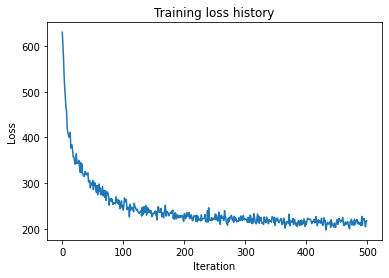

In [ ]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)

device = "cuda"
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10,2) # a new loader

for lr in [1e-4]:
  print('lr: ', lr)
  detector = TwoStageDetector(roi_output_w = 2, roi_output_h=2,anchor_size=4)
  DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=500,device=device)